In [2]:
import torch
from torch import nn
import torch.optim as optim

import torchtext
import pandas as pd
import numpy as np
import sklearn.metrics
from collections import defaultdict
from tqdm import tqdm

from models import MLP1Base, MLP2Base, MetaMLPModel
from torchmeta.modules import MetaLinear
import scipy.stats

In [3]:
df=pd.read_csv('./parallelograms-revisited/experiment2_data_relational_similarity/mean_relsim_ratings.csv')

In [10]:
len(df)

6194

In [27]:
test2 = np.array(df['mean_rating'])

In [30]:
scipy.stats.pearsonr(test, test2)

(-0.023011340873293835, 0.0701544591789242)

In [4]:
vocab = torchtext.vocab.GloVe(name='840B', dim=300)

In [11]:
man = vocab['man']
woman = vocab['woman']
king = vocab['king']
queen = vocab['queen']
v_queen = woman-man+king
p_sim = sklearn.metrics.pairwise.cosine_similarity(v_queen.reshape(1, -1), vocab.vectors)

In [12]:
p_sorted_indices = (-p_sim).argsort()[0]
p_sorted_indices[:10]

array([ 3598,  7613, 13825, 13063, 10634,  8524, 14704, 25858, 33859,
        3084])

In [15]:
vocab.itos[7613]

'queen'

In [6]:
# sgd_linear_params = torch.load('./models/sgd_linear.pt', map_location=torch.device('cpu'))
# sgd_mlp1_params = torch.load('./models/sgd_mlp1.pt', map_location=torch.device('cpu'))
# sgd_mlp2_params = torch.load('./models/sgd_mlp2.pt', map_location=torch.device('cpu'))
meta_linear_params = torch.load('./models/meta_linear.pt', map_location=torch.device('cpu'))
meta_mlp1_params = torch.load('./models/meta_mlp1.pt', map_location=torch.device('cpu'))
meta_mlp2_params = torch.load('./models/meta_mlp2.pt', map_location=torch.device('cpu'))

In [7]:
meta_linear = nn.Linear(in_features=300, out_features=300)
meta_mlp1 = MLP1Base(input_dim=300, hidden_dim=500, output_dim=300)
meta_mlp2 = MLP2Base(input_dim=300, hidden_dim=500, output_dim=300)
# sgd_linear = nn.Linear(in_features=900, out_features=300)
# sgd_mlp1 = MLP1Base(input_dim=900, hidden_dim=1000, output_dim=300)
# sgd_mlp2 = MLP2Base(input_dim=900, hidden_dim=1000, output_dim=300)

In [12]:
sgd_linear.weight.data = sgd_linear_params['linear.weight']
sgd_linear.bias.data = sgd_linear_params['linear.bias']

In [13]:
sgd_mlp1.l1.weight.data = sgd_mlp1_params['l1.weight']
sgd_mlp1.l1.bias.data = sgd_mlp1_params['l1.bias']
sgd_mlp1.l2.weight.data = sgd_mlp1_params['l2.weight']
sgd_mlp1.l2.bias.data = sgd_mlp1_params['l2.bias']

sgd_mlp2.l1.weight.data = sgd_mlp2_params['l1.weight']
sgd_mlp2.l1.bias.data = sgd_mlp2_params['l1.bias']
sgd_mlp2.l2.weight.data = sgd_mlp2_params['l2.weight']
sgd_mlp2.l2.bias.data = sgd_mlp2_params['l2.bias']
sgd_mlp2.l3.weight.data = sgd_mlp2_params['l3.weight']
sgd_mlp2.l3.bias.data = sgd_mlp2_params['l3.bias']

In [8]:
meta_linear.weight.data = meta_linear_params['weight']
meta_linear.bias.data = meta_linear_params['bias']

In [9]:
meta_mlp1.l1.weight.data = meta_mlp1_params['features.layer1.linear.weight']
meta_mlp1.l1.bias.data = meta_mlp1_params['features.layer1.linear.bias']
meta_mlp1.l2.weight.data = meta_mlp1_params['classifier.weight']
meta_mlp1.l2.bias.data = meta_mlp1_params['classifier.bias']

meta_mlp2.l1.weight.data = meta_mlp2_params['features.layer1.linear.weight']
meta_mlp2.l1.bias.data = meta_mlp2_params['features.layer1.linear.bias']
meta_mlp2.l2.weight.data = meta_mlp2_params['features.layer2.linear.weight']
meta_mlp2.l2.bias.data = meta_mlp2_params['features.layer2.linear.bias']
meta_mlp2.l3.weight.data = meta_mlp2_params['classifier.weight']
meta_mlp2.l3.bias.data = meta_mlp2_params['classifier.bias']

In [14]:
sgd_linear.eval()
sgd_mlp1.eval()
sgd_mlp2.eval()

MLP2Base(
  (l1): Linear(in_features=900, out_features=1000, bias=True)
  (l2): Linear(in_features=1000, out_features=1000, bias=True)
  (l3): Linear(in_features=1000, out_features=300, bias=True)
)

In [21]:
def get_sgd_linear(a, b, c):
    tot = torch.cat((a, b, c), dim=0)
    return sgd_linear(tot).detach().numpy()

def get_sgd_mlp1(a, b, c):
    tot = torch.cat((a, b, c), dim=0)
    return sgd_mlp1(tot).detach().numpy()

def get_sgd_mlp2(a, b, c):
    tot = torch.cat((a, b, c), dim=0)
    return sgd_mlp2(tot).detach().numpy()

In [19]:
def get_relsim_scores(df, vocab, model, get_loss):
    relsim_scores = [0] * len(df)
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        forward = get_loss(a, b, c, d)
        backward = get_loss(c, d, a, b)

        relsim_scores[idx] = forward - backward
    return relsim_scores

In [29]:
test = get_relsim_scores(df, vocab, meta_mlp1, get_m2_loss)

6194it [00:27, 221.53it/s]


In [23]:
test

[-0.018767506,
 0.09954381,
 -0.03525412,
 -0.09265709,
 0.1251333,
 0.17920792,
 -0.18363458,
 -0.15251923,
 -0.014952302,
 0.30260786,
 -0.043496788,
 -0.13546398,
 -0.11350751,
 -0.16951862,
 -0.005772263,
 -0.15389785,
 -0.14338571,
 -0.0860078,
 0.070029646,
 -0.21761322,
 0.023947299,
 0.050356895,
 -0.00051790476,
 -0.07395384,
 -0.17974043,
 -0.023407876,
 -0.08240765,
 -0.016040295,
 -0.12610707,
 0.03378132,
 -0.09467739,
 0.02052477,
 0.30844516,
 0.16862229,
 -0.0052875876,
 0.01322633,
 -0.1304133,
 0.2662907,
 -0.045146823,
 -0.010691106,
 0.13427904,
 -0.016159743,
 0.13668746,
 0.21988827,
 0.16349235,
 0.044872224,
 0.034783006,
 -0.04589495,
 0.08280313,
 -0.074023455,
 -0.22806737,
 0.054167956,
 0.17737553,
 -0.27305245,
 0.118754536,
 -0.06516191,
 -0.14816037,
 0.012827933,
 -0.16134977,
 -0.016043484,
 -0.17707199,
 0.018798113,
 0.02278626,
 -0.109470695,
 0.06351215,
 -0.060463756,
 -0.00879547,
 0.15376988,
 -0.10118142,
 0,
 0.21293941,
 0.060468197,
 0.03027

In [21]:
mlopt = optim.SGD(meta_linear.parameters(), lr=0.1)
mm1opt = optim.SGD(meta_mlp1.parameters(), lr=0.1)
mm2opt = optim.SGD(meta_mlp2.parameters(), lr=0.1)

mlcache = meta_linear.state_dict()
mm1cache = meta_mlp1.state_dict()
mm2cache = meta_mlp2.state_dict()

criterion = nn.MSELoss()

def get_ml_loss(a, b, c, d):
    meta_linear.load_state_dict(mlcache)
    mlopt.zero_grad()
    a_hat = meta_linear(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mlopt.step()
    c_hat = meta_linear(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

def get_m1_loss(a, b, c, d):
    meta_mlp1.load_state_dict(mm1cache)
    mm1opt.zero_grad()
    a_hat = meta_mlp1(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mlopt.step()
    c_hat = meta_linear(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

def get_m2_loss(a, b, c, d):
    meta_mlp2.load_state_dict(mm2cache)
    mm2opt.zero_grad()
    a_hat = meta_mlp2(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mlopt.step()
    c_hat = meta_linear(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

In [54]:
mlopt = optim.SGD(meta_linear.parameters(), lr=0.1)
mm1opt = optim.SGD(meta_mlp1.parameters(), lr=0.01)
mm2opt = optim.SGD(meta_mlp2.parameters(), lr=0.1)

mlcache = meta_linear.state_dict()
mm1cache = meta_mlp1.state_dict()
mm2cache = meta_mlp2.state_dict()

criterion = nn.MSELoss()

def get_meta_linear(a, b, c):
    meta_linear.load_state_dict(mlcache)
    mlopt.zero_grad()
    ahat = meta_linear(a)
    loss = criterion(ahat, b)
    loss.backward()
    mlopt.step()
    return meta_linear(c).detach().numpy()

def get_m1(a, b, c):
    meta_mlp1.load_state_dict(mm1cache)
    mm1opt.zero_grad()
    ahat = meta_mlp1(a)
    loss = criterion(ahat, b)
    loss.backward()
    mm1opt.step()
    return meta_mlp1(c).detach().numpy()

def get_m2(a, b, c):
    meta_mlp2.load_state_dict(mm2cache)
    mm2opt.zero_grad()
    ahat = meta_mlp2(a)
    loss = criterion(ahat,b)
    loss.backward()
    mm2opt.step()
    return meta_mlp2(c).detach().numpy()

In [55]:
mm1_ranks = np.zeros(len(vocab.itos))
update_ranks(df, vocab, mm1_ranks, get_m1)

22it [01:33,  4.29s/it]

foresight future X-ray


25it [01:42,  3.84s/it]

lamb chop lamb chapter


31it [02:03,  4.08s/it]

launchpad helicopter diving board


34it [02:12,  3.72s/it]

basketball hoop soccer ball


36it [02:16,  3.24s/it]

law school lawyer medical school


43it [02:42,  4.06s/it]

basket picnic lunch box


45it [02:46,  3.49s/it]

furnace coal wood stove


61it [03:50,  4.29s/it]

movie screen game show


65it [04:03,  3.97s/it]

lamb chop lamb pork chop


71it [04:25,  4.09s/it]

flock goose wolf pack


78it [04:51,  4.17s/it]

law school lawyer vineyard


80it [04:55,  3.69s/it]


In [10]:
def get_ranks(df, cd_ranks, p_ranks, sgd_linear, sgd_mlp1, sgd_mlp2, meta_linear, meta_mlp1, meta_mlp2):
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3 = row['prompt_w1'], row['prompt_w2'], row['prompt_w3']
        # print(w1, w2, w3)

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi:
            print(w1, w2, w3)
            continue
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        
        row.pop('prompt_w1')
        row.pop('prompt_w2')
        row.pop('prompt_w3')
        
        # print('popped')

        cd_sim = sklearn.metrics.pairwise.cosine_similarity(c.reshape(1, -1), vocab.vectors)
        cd_sorted_indices = (-cd_sim).argsort()[0]
        cd_stoi = dict(zip(vocab.itos, cd_sorted_indices))

        d = b - a + c 
        p_sim = sklearn.metrics.pairwise.cosine_similarity(d.reshape(1, -1), vocab.vectors)
        p_sorted_indices = (-p_sim).argsort()[0]
        p_stoi = dict(zip(vocab.itos, p_sorted_indices))
        
        # print('constructed stoi')
        
        for key, value in row.items():
            if key not in cd_stoi:
                continue
            cd_idx = cd_stoi[key]
            cd_ranks[cd_idx] += value

            p_idx = p_stoi[key]
            p_ranks[p_idx] += value

In [ ]:
cd_ranks = np.zeros(len(vocab.itos))
p_ranks = np.zeros(len(vocab.itos))
get_ranks(df, cd_ranks, p_ranks)

In [56]:
mm1_cumsum = np.cumsum(mm1_ranks)

In [26]:
pcts = np.arange(len(sgdm1_cumsum)) / len(sgdm1_cumsum) * 100

In [57]:
mm1_cumsum_pct = mm1_cumsum / mm1_cumsum[-1]

In [28]:
import matplotlib.pyplot as plt

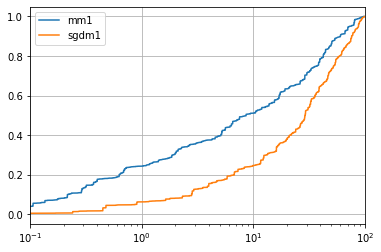

In [58]:
fig, ax = plt.subplots()
ax.plot(pcts, mm1_cumsum_pct, label='mm1')
ax.plot(pcts, sgdm1_cumsum_pct, label='sgdm1')

ax.set_xscale('log')
ax.set_xlim((1e-1, 1e2))
ax.legend()
ax.grid()

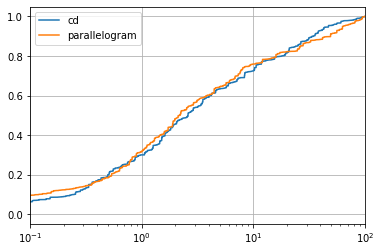

In [22]:
fig, ax = plt.subplots()
ax.plot(pcts, cd_cumsum_pct, label='cd')
ax.plot(pcts, p_cumsum_pct, label='parallelogram')

ax.set_xscale('log')
ax.set_xlim((1e-1, 1e2))
ax.legend()
ax.grid()

In [53]:
with open('test.npy', 'wb') as f:
    np.save(f, mm1_cumsum_pct)
    np.save(f, sgdm1_cumsum_pct)